In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import chi2
import cython
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%load_ext Cython


from KalmanFilter import KalmanFilter as KFPedro
from KF_py import KalmanFilter as KF
from KF_py2 import KalmanFilter as KF2
from KalmanFilter_Uni import KalmanFilter as KFU
from KalmanFilter_UniCy import KalmanFilter as KFUC


%load_ext autotime
%load_ext snakeviz

# Bayesian Econometrics - Final Paper

Paper to be delivered as the course's final paper

Pedro Montero Mattos

MPE - Econometria

\#333791

# The Model - Local Level with Seasonal Component

As described in the chapter 4 in Koopman et al. The local level model with a seasonal component consists of the following equations:

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = -\gamma_{t} - \gamma_{t-1} - \theta_1\gamma_{t-2} + \omega_t \sim NID(0,\sigma^2_\omega) $$


We added a $\theta$ coefficient in order to use maximum likelihood estimation

## State Space Form

General Form:

$$ y_t = Z x_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$
$$ x_{t+1} = T x_t + R_t \eta_T, \qquad \eta_t \sim NID(0,Qt) $$

In terms of the model:
$$ 
x_t = 
\begin{pmatrix}\mu_t \\ \gamma_t  \\  \gamma_{t-1}   \\ \gamma_{t-2}  \end{pmatrix}
$$

$$
\eta_t = 
\begin{pmatrix}\xi_t \\ \omega_t \end{pmatrix}
$$

$$
T_t = 
\begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & -1 & -1 & -\theta_1 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 
\end{bmatrix}
$$



$$
Z^T_t = 
\begin{pmatrix}1 \\ 1  \\  0   \\ 0  \end{pmatrix}
$$

$$
Q_t = 
\begin{bmatrix} 
\sigma^2_\xi & 0 \\
0 & \sigma^2_\omega \\
\end{bmatrix}
$$

$$
R_t = 
\begin{bmatrix} 
1 & 0  \\
0 & 1  \\
0 & 0  \\
0 & 0  \\
\end{bmatrix}
$$

$$
H_t = 
\begin{bmatrix} 
\sigma^2_\epsilon
\end{bmatrix}
$$

# Generating the data for $\theta_1=0.7$

We have to choose all parameter values plus the initial states

$$\gamma_t = \gamma_{t-1} = \gamma_{t-2} = 0$$
$$\theta_1 = 0.7$$
$$\sigma^2_\xi = 0.1$$
$$\sigma^2_\omega = 0.2$$
$$\sigma^2_\epsilon = 0.3$$




In [2]:
n = 200
theta1 = 0.7
sigmaXi = 0.1 ** 0.5
sigmaOmega = 0.2 ** 0.5
sigmaEpsilon = 0.3 ** 0.5

time: 2.03 ms


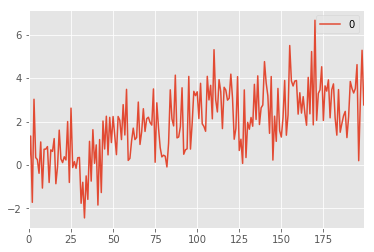

time: 375 ms


In [3]:
y = np.array([0])
mi = np.array([0])
gamma = np.array([0])

xi = np.array([0])
omega = np.array([0])
ep = np.array([0])

for i in range(1,n):

    # Level equation
    xi = np.append(xi,np.random.normal(scale=sigmaXi))
    mi = np.append(mi,mi[i-1]+xi[i])
    
    # Seasonality equation
    omega = np.append(omega,np.random.normal(scale=sigmaOmega))
    holder = 0
    if i-1 >= 0:
        holder -= gamma[i-1] 
    if i-2 >= 0:
        holder -= gamma[i-2] 
    if i-3 >= 0:
        holder -= gamma[i-3] * theta1
    
    gamma = np.append(gamma,holder+omega[i])
    
    # Series equation
    ep = np.append(ep,np.random.normal(scale=sigmaEpsilon))
    y = np.append(y,mi[i]+gamma[i]+ep[i])

y = pd.DataFrame(y) 
mi = pd.DataFrame(mi) 
gamma = pd.DataFrame(gamma) 

nny = y.copy()
probNan= 0.20
for i in nny.index:
    ran = np.random.uniform(size=nny.iloc[i].shape)
    nny.iloc[i][ran<probNan] = np.nan



y.plot()

# Maximum Likelihood Estimates

Define a wrapper function that maps the theta vector of parameters to the state space matrices

$$\theta = [\theta_1, \sigma^2_\epsilon, \sigma^2_\xi, \sigma^2_\omega]'$$

The functions return the negative of the likelihood because the scipy optimization algorithms only minimize functions. Also we use the logarithm for numerical reasons.

In [4]:
def wrapper(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta[0]],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([theta[1]])

    Q = pd.DataFrame([
        [theta[2],0],
        [0,theta[3]],
    ])

    kf = KF(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return -np.log(kf['ll']*10e6)

time: 9.02 ms


## Define the additional state space matrices

In [5]:
Z = pd.DataFrame([
        [1,1,0,0],
    ])

R = pd.DataFrame([
        [1,0],
        [0,1],
        [0,0],
        [0,0],
    ])

time: 8.02 ms


Minimize the wrapper function, with the following initial values for $\theta$:

$$\theta = [0.5, 1, 1, 1]'$$
    

In [6]:
initialTheta = np.array([0.5,1.0,1.0,1.0])

time: 4.01 ms


In [7]:
minimize(wrapper,initialTheta, 
         options={'disp':True, 'maxiter':1000}, 
#          bounds = ((-5,5),(None,None),(None,None),(None,None),), 
         method='SLSQP',
         )

O:\SALES\Fundos de Mercado\Notebooks\BayesianEconometrics\KF_py.py:147: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(Ft[:dims[t],:dims[t],t])) + vt[t,inds[t,:]].T.dot(inv(Ft[:dims[t],:dims[t],t])).dot(vt[t,inds[t,:]])


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 294.93728862504634
            Iterations: 14
            Function evaluations: 104
            Gradient evaluations: 14


     fun: 294.93728862504634
     jac: array([-0.00118637,  0.00421524,  0.01306534,  0.00110245])
 message: 'Optimization terminated successfully.'
    nfev: 104
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([ 0.7161773 ,  0.3551761 ,  0.12529562,  0.21260129])

time: 2.4 s


In [8]:
minimize(wrapper,initialTheta, 
         options={'disp':True, 'maxiter':500}, 
#          bounds = ((-5,5),(None,None),(None,None),(None,None),), 
         method='Powell',
         )

O:\SALES\Fundos de Mercado\Notebooks\BayesianEconometrics\KF_py.py:147: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(Ft[:dims[t],:dims[t],t])) + vt[t,inds[t,:]].T.dot(inv(Ft[:dims[t],:dims[t],t])).dot(vt[t,inds[t,:]])
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1849: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2439: RuntimeWarning: invalid value encountered in double_scalars
  if (fx2 - fval) > delta:
C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2448: RuntimeWarning: invalid value encountered in double_scalars
  if 2.0 * (fx - fval) <= bnd:


   direc: array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])
     fun: inf
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 24543
     nit: 500
  status: 2
 success: False
       x: array([ 1286.62184956,  1281.39772844,  1291.88884112,  1295.77545883])

time: 7min 31s


In [9]:
minimize(wrapper,initialTheta, 
         options={'disp':True, 'maxiter':500}, 
#          bounds = ((-5,5),(None,None),(None,None),(None,None),), 
         method='BFGS',
         )

O:\SALES\Fundos de Mercado\Notebooks\BayesianEconometrics\KF_py.py:147: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(Ft[:dims[t],:dims[t],t])) + vt[t,inds[t,:]].T.dot(inv(Ft[:dims[t],:dims[t],t])).dot(vt[t,inds[t,:]])
O:\SALES\Fundos de Mercado\Notebooks\BayesianEconometrics\KF_py.py:147: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(Ft[:dims[t],:dims[t],t])) + vt[t,inds[t,:]].T.dot(inv(Ft[:dims[t],:dims[t],t])).dot(vt[t,inds[t,:]])


         Current function value: nan
         Iterations: 1
         Function evaluations: 672
         Gradient evaluations: 112


O:\SALES\Fundos de Mercado\Notebooks\BayesianEconometrics\KF_py.py:147: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(Ft[:dims[t],:dims[t],t])) + vt[t,inds[t,:]].T.dot(inv(Ft[:dims[t],:dims[t],t])).dot(vt[t,inds[t,:]])


      fun: nan
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([ nan,  nan,  nan,  nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 672
      nit: 1
     njev: 112
   status: 2
  success: False
        x: array([ 325.22224759, -381.4066504 , -575.52752881, -695.84216418])

time: 12.4 s


In [10]:
minimize(wrapper,initialTheta, 
         options={'disp':True, 'maxiter':500}, 
#          bounds = ((-5,5),(None,None),(None,None),(None,None),), 
         method='Nelder-Mead',
         )

O:\SALES\Fundos de Mercado\Notebooks\BayesianEconometrics\KF_py.py:147: RuntimeWarning: invalid value encountered in log
  ll += np.log(det(Ft[:dims[t],:dims[t],t])) + vt[t,inds[t,:]].T.dot(inv(Ft[:dims[t],:dims[t],t])).dot(vt[t,inds[t,:]])


Optimization terminated successfully.
         Current function value: 294.937289
         Iterations: 253
         Function evaluations: 422


 final_simplex: (array([[ 0.7161841 ,  0.35515253,  0.12528696,  0.21261491],
       [ 0.71618144,  0.35513221,  0.12528192,  0.21260937],
       [ 0.71619226,  0.35516436,  0.12528695,  0.21259281],
       [ 0.71620049,  0.35519677,  0.1252675 ,  0.21259991],
       [ 0.71619021,  0.35523233,  0.12526888,  0.21257142]]), array([ 294.93728855,  294.93728855,  294.93728856,  294.93728863,
        294.93728866]))
           fun: 294.93728854558583
       message: 'Optimization terminated successfully.'
          nfev: 422
           nit: 253
        status: 0
       success: True
             x: array([ 0.7161841 ,  0.35515253,  0.12528696,  0.21261491])

time: 7.5 s


# Bayesian Estimates

## Wrapper, Priors and Posteriors

We chose to use the following priors:

$$\theta_1 \sim N(0,1)$$
$$\sigma^2_\epsilon \sim \chi_2(1)$$
$$\sigma^2_\xi \sim \chi_2(1)$$
$$\sigma^2_\omega \sim \chi_2(1)$$

In [11]:
def posterior(theta,priorMeans, priorVariances):
    
    i=0
    priors = []
    priors.append(norm.pdf(theta[i],priorMeans[i],priorVariances[i]))
    priors.append(chi2.pdf(theta[1],1))
    priors.append(chi2.pdf(theta[2],1))
    priors.append(chi2.pdf(theta[3],1))
    
    
    temp = priors[i]
    for i in range(1,3+1):
        temp *= priors[i]
    
    ll = wrapper(theta)


#     ll *= 10e-200
#     print(ll)
    return {'post' : ll * temp, 'priors' : np.array(priors)}

time: 9.53 ms


In [12]:
def wrapper(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta[0]],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([theta[1]])

    Q = pd.DataFrame([
        [theta[2],0],
        [0,theta[3]],
    ])

    kf = KFUC(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return kf


time: 10 ms


## MCMC - Metropolis Hastings

We chose to use a random walk metropolis hastings of the form

---
**Metropolis-Hastings Algoritm**

Guess $\theta^{(0)}$ and for $i=0$ until $n$: 
1. $\theta=\theta^{(i-1)} + \eta_t$ where $\eta_t \sim N(0,\sigma)$
2. Compute $r=\min(1,\alpha)$ where $\alpha= \frac{p(\theta')q(\theta|\theta')}{p(\theta)q(\theta'|\theta)}$
4. Draw $u\sim U(0,1)$
5. $\theta^{(i+1)}=\begin{cases}\theta' & \text{if $u<r$}\\\theta & \text{if $u\geq r$}\end{cases}$

---

We use the logarithmic transformations for all variance parameters

In [13]:
def randomWalkMH(sample,burn, initialTheta, 
                 randomWalkSigmas,priorMeans,priorVariances):

    thetaMH = []
    accept = np.zeros([sample])
    posts = np.zeros([sample])
    rs = []
    thetaMH.append(initialTheta)
    priors = np.zeros([sample,4])

    thetastemps = []
    disturbances = []

    for i in range(1,sample):
        disturbance = np.multiply(np.random.randn(thetaMH[0].shape[0]),
                                  randomWalkSigmas)
    #     disturbance[1:] = np.exp(disturbance[1:]) #problema está aqui
    #     print(disturbance)
        thetaTemp = thetaMH[i-1].copy()
        thetaTemp[1:] = np.log(thetaMH[i-1][1:].copy())+disturbance[1:].copy()
        thetaTemp[1:] = np.exp(thetaTemp[1:].copy())
        thetaTemp[0] = thetaTemp[0].copy() + disturbance[0].copy()
        disturbances.append(disturbance.copy())
        thetastemps.append(thetaTemp.copy())
    #     print(thetaTemp)
    #     print(thetastemps[i-1])
    #     thetaTemp = (temp)
        tempPost = posterior(thetaTemp,priorMeans, priorVariances)
        lalpha = np.log(tempPost['post']) - np.log(posts[i-1])
        r = np.min([1, np.exp(lalpha)])
        rs.append(r)
        u = np.random.uniform()

        if u < r:
            accept[i] = 1
            thetaMH.append(thetaTemp.copy())
            posts[i] = tempPost['post'].copy()
            priors[i] = tempPost['priors'].copy()
        else:
            thetaMH.append(thetaMH[i-1].copy())
            posts[i] = posts[i-1].copy()
            priors[i] = priors[i-1].copy()

    post = pd.DataFrame(thetaMH)
    return {'posterior' : post[burn:], 
#             'post'
            'accept' : accept, 
            'disturbances' : pd.DataFrame(disturbances),
           'rs' : pd.DataFrame(rs),
           'priors': pd.DataFrame(priors)}

time: 32.1 ms


In [14]:
initialSigmas = 5.0
initialTheta = np.array([0.3,initialSigmas,initialSigmas,initialSigmas])

time: 5.01 ms


In [15]:
sample = 20000

sigma = 0.1
randomWalkSigmas = np.array([0.1,sigma,sigma,sigma])

priorMeans = np.array([0,0,0,0])

priorVariances = np.array([0.1,1,1,1])

mcmc = randomWalkMH(sample = sample,
                 burn = 1000, 
                 initialTheta = initialTheta, 
                 randomWalkSigmas = randomWalkSigmas,
                 priorMeans = priorMeans,
                 priorVariances = priorVariances)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: RuntimeWarning: divide by zero encountered in log


time: 3min 15s


**Acceptance Ratio**

In [16]:
mcmc['accept'].sum() / mcmc['accept'].shape[0]

0.39350000000000002

time: 2.51 ms


In [17]:
wrapper(mcmc['posterior'].iloc[50])

3.064436430290647e-140

time: 22.1 ms


## Marginal distribution for $\theta_1$

True value is $0.7$

In [19]:
par = 0

time: 1.01 ms


In [20]:
mcmc['posterior'][par].describe()

count    19000.000000
mean         0.539988
std          0.050394
min          0.257172
25%          0.507848
50%          0.542427
75%          0.573880
max          0.709057
Name: 0, dtype: float64

time: 11 ms


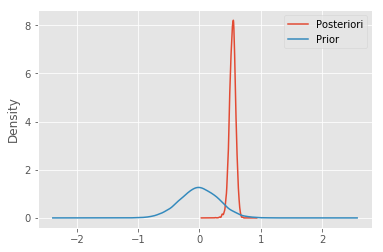

time: 1.46 s


In [21]:
plt.figure()
# mcmc['posterior'][par].plot.density()
prior = pd.DataFrame(np.random.normal(loc=priorMeans[par]
                                      ,scale=priorVariances[par] ** 0.5
                                      ,size=mcmc['posterior'][par].shape[0]))
prior.columns = ['Prior']
poster = pd.DataFrame(mcmc['posterior'][par])
poster.columns = ['Posteriori']
pd.concat([poster, prior], axis=1).plot.density()
# pd.DataFrame(norm.pdf(np.arange(-3,3,0.1))).plot()



## Marginal distribution for $\sigma^2_\epsilon$

True value is $0.3$

In [22]:
par = 1

time: 501 µs


In [23]:
mcmc['posterior'][par].describe()

count    1.900000e+04
mean     6.863589e-02
std      1.391335e-01
min      2.616985e-13
25%      1.345462e-08
50%      2.139929e-05
75%      5.733121e-02
max      1.015554e+00
Name: 1, dtype: float64

time: 15.5 ms


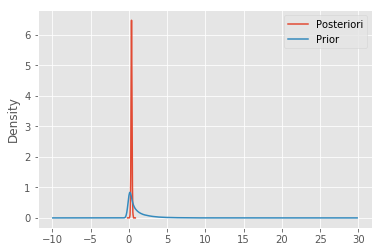

time: 1.64 s


In [42]:
plt.figure()
# mcmc['posterior'][par].plot.density()
prior = pd.DataFrame(np.random.chisquare(1 ,
                                         size=mcmc['posterior'][par].shape[0]))
prior.columns = ['Prior']
poster = pd.DataFrame(mcmc['posterior'][par])
poster.columns = ['Posteriori']
pd.concat([poster, prior], axis=1).plot.density()
# pd.DataFrame(norm.pdf(np.arange(-3,3,0.1))).plot()



## Marginal distribution for $\sigma^2_\xi$

True value is $0.1$

In [25]:
par = 2

time: 501 µs


In [26]:
mcmc['posterior'][par].describe()

count    19000.000000
mean         0.221489
std          0.062014
min          0.026734
25%          0.190000
50%          0.226761
75%          0.260606
max          0.475690
Name: 2, dtype: float64

time: 10 ms


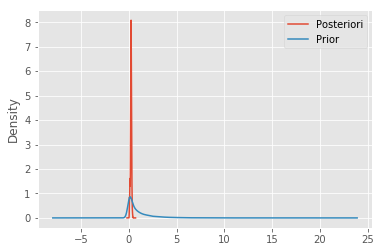

time: 1.56 s


In [27]:
plt.figure()
# mcmc['posterior'][par].plot.density()
prior = pd.DataFrame(np.random.chisquare(1 ,
                                         size=mcmc['posterior'][par].shape[0]))
prior.columns = ['Prior']
poster = pd.DataFrame(mcmc['posterior'][par])
poster.columns = ['Posteriori']
pd.concat([poster, prior], axis=1).plot.density()
# pd.DataFrame(norm.pdf(np.arange(-3,3,0.1))).plot()



## Marginal distribution for $\sigma^2_\omega$

True value is $0.2$

In [28]:
par = 3

time: 1 ms


In [29]:
mcmc['posterior'][par].describe()

count    19000.000000
mean         0.343621
std          0.064951
min          0.085772
25%          0.301423
50%          0.343144
75%          0.385320
max          0.589562
Name: 3, dtype: float64

time: 10 ms


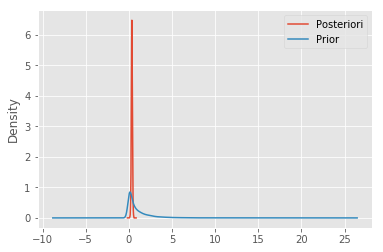

time: 1.58 s


In [30]:
plt.figure()
# mcmc['posterior'][par].plot.density()
prior = pd.DataFrame(np.random.chisquare(1 ,
                                         size=mcmc['posterior'][par].shape[0]))
prior.columns = ['Prior']
poster = pd.DataFrame(mcmc['posterior'][par])
poster.columns = ['Posteriori']
pd.concat([poster, prior], axis=1).plot.density()
# pd.concat([poster, prior], axis=1).hist(stack=True)
# pd.DataFrame(norm.pdf(np.arange(-3,3,0.1))).plot()



# Performance Optimization

## Profiling the Kalman Filter

Profiling should always be the first step on every optimization

We'll profile the KF with the true values

In [31]:
def KF_func(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-0.7],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([0.3])

    Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])

    kf = KF(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return kf['ll']


time: 8.52 ms


In [32]:
%%snakeviz

KF_func(0)

 
*** Profile stats marshalled to file 'C:\\Users\\PEDRO~1.MAT\\AppData\\Local\\Temp\\tmpnybibfi9'. 
time: 3.05 s


The problem is that dot products and matrix inversions are already optimized in fortran and C

## Univariate Approach

Makes best use of cython

In [33]:
def KF_funcUni(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-0.7],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([0.3])

    Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])

    kf = KFU(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return kf



time: 15.5 ms


In [34]:
%%timeit
KF_func(0)

10 loops, best of 3: 20.4 ms per loop
time: 894 ms


In [35]:
%%timeit
KF_funcUni(0)

100 loops, best of 3: 11 ms per loop
time: 4.62 s


In [36]:
%%snakeviz

KF_funcUni(0)

 
*** Profile stats marshalled to file 'C:\\Users\\PEDRO~1.MAT\\AppData\\Local\\Temp\\tmpxcy91afb'. 
time: 3.03 s


Since dot is already optimized we will move on to cython

In [37]:
def KF_funcUniC(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-0.7],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([0.3])

    Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])

    kf = KFUC(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return kf




time: 10.5 ms


In [38]:
%%timeit
KF_funcUniC(0)

100 loops, best of 3: 10.1 ms per loop
time: 4.3 s


Further ideas:

* Eliminate whole line assignments using loops (First check whether that's actually faster)

# Code for the Kalman Filter

In [39]:
import numpy as np
from numpy.linalg import inv
from numpy.linalg import det
import pandas as pd
import datetime as dt




def KalmanFilter(y, nStates, Z, H, T, Q, a1, P1, R, export=False):
# Only receives np arrays

    p = y.shape[1]
    n = y.shape[0]
    m = nStates


    yhat = np.empty((n, p))
    Z = np.array(Z.astype(float))  # (PxM) we'll drop t
    H = np.array(H.astype(float))
    T = np.array(T.astype(float))  # Should be M x M
    Q = np.array(Q.astype(float))  # (RxR)
    a = np.empty((n + 1, p + 1, m))  # each alpha t,i is mx1
    a[0, 0, :] = np.array(a1.astype(float)).ravel()  # TODO Check a1 dimension
    P = np.empty((n + 1, p + 1, m, m))
    P[0, 0, :, :] = np.array(P1.astype(float))
    v = np.empty((n, p))
    F = np.empty((n, p))
    K = np.empty((n, p, m))
    ZT = Z.T  # To avoid transposing it several times
    TT = T.T  # To avoid transposing it several times
    R = np.array(R)  # (MxR)
    RT = R.T
    ll = 0


    for t in range(0, n):
        ind = ~np.isnan(y[t, :])
        templl = 0
        pst = 0
        for i in range(0, p):  # later on change to Pt
            if ind[i]:
                v[t, i] = y[t, i] - Z[i, :].reshape((1, m)).dot(a[t, i, :].T)  # a should be mx1
                F[t, i] = Z[i, :].reshape((1, m)).dot(P[t, i, :, :]).dot(Z[i, :]) + H[i, i]
                K[t, i, :] = P[t, i, :, :].dot(Z[i, :]) * F[t, i] ** (-1)
                a[t, i + 1, :] = a[t, i, :] + K[t, i, :] * v[t, i]
                P[t, i + 1, :, :] = P[t, i, :, :] - (K[t, i, :] * 
                        F[t, i]).reshape((m, 1)).dot(
                    K[t, i].reshape((1, m)))
            else:
                # Setting all Z's to zeros
                v[t, i] = np.zeros(v[t, i].shape)
                F[t, i] = H[
                    i, i]
                K[t, i, :] = np.zeros(K[t, i, :].shape)
                a[t, i + 1, :] = a[t, i, :] + K[t, i, :] * v[t, i]
                P[t, i + 1, :, :] = P[t, i, :, :] - (K[t, i, :] * 
                                                     F[t, i]).reshape(
                    (m, 1)).dot(K[t, i].reshape((1, m)))
            if F[t,i] != 0:
                templl += np.log(F[t,i]) + (v[t,i] ** 2) / F[t,i]
                pst += 1

        ll+= pst * np.log(2*np.pi) + templl


        a[t + 1, 0, :] = T.dot(a[t, i + 1, :])
        P[t + 1, 0, :, :] = T.dot(P[t, i + 1]).dot(TT) + R.dot(Q).dot(RT)
        # yhat[t,:] = Z.dot(a[t,1,:]) # ERRADO

        if export:
            yhat[t, :] = Z.dot(a[t, 0, :])

    ll *= -0.5
    ll = np.exp(ll)

    if export:
        states = pd.DataFrame(a[:, 0, :])
        yhat = pd.DataFrame(yhat)
        y = pd.DataFrame(y)
        return {'states' : states,
                'yhat' : yhat,
                'y' : y,
                'll' : ll}
    else:
        return ll


time: 102 ms


## In Cython

In [40]:
import numpy as np
cimport numpy as np
import pandas as pd
import datetime as dt

DTYPE = np.float64
DTYPEI = np.int

ctypedef np.float64_t DTYPE_t
ctypedef np.int_t DTYPEI_t


def KalmanFilter(np.ndarray[DTYPE_t, ndim = 2] y,
                DTYPEI_t nStates,
                np.ndarray[DTYPE_t, ndim = 2] Z,
                np.ndarray[DTYPE_t, ndim = 2] H,
                np.ndarray[DTYPE_t, ndim = 2] T,
                np.ndarray[DTYPE_t, ndim = 2] Q,
                np.ndarray[DTYPE_t, ndim = 1] a1,
                np.ndarray[DTYPE_t, ndim = 2] P1,
                np.ndarray[DTYPE_t, ndim = 2] R,
                                 export=False):
# Only receives np arrays

    cdef DTYPEI_t p = y.shape[1]
    cdef DTYPEI_t n = y.shape[0]
    cdef DTYPEI_t m = nStates
    cdef DTYPEI_t t, i

    cdef np.ndarray[DTYPE_t, ndim = 2] yhat = np.empty((n, p), dtype=DTYPE)
    cdef np.ndarray[DTYPE_t, ndim = 3] a = np.empty((n + 1, p + 1, m), 
                                                    dtype=DTYPE)  # each alpha t,i is mx1
    a[0, 0, :] = a1
    cdef np.ndarray[DTYPE_t, ndim = 4] P = np.empty((n + 1, p + 1, m, m), 
                                                    dtype=DTYPE)
    P[0, 0, :, :] = np.array(P1.astype(float), dtype=DTYPE)
    cdef np.ndarray[DTYPE_t, ndim = 2] v = np.empty((n, p), dtype=DTYPE)
    cdef np.ndarray[DTYPE_t, ndim = 2] F = np.empty((n, p), dtype=DTYPE)
    cdef np.ndarray[DTYPE_t, ndim = 3] K = np.empty((n, p, m), dtype=DTYPE)
    cdef np.ndarray[DTYPE_t, ndim = 2] ZT = Z.T  # To avoid transposing it several times
    cdef np.ndarray[DTYPE_t, ndim = 2] TT = T.T  # To avoid transposing it several times
    cdef np.ndarray[DTYPE_t, ndim = 2] RT = R.T
    cdef DTYPE_t ll = 0
    cdef DTYPE_t templl = 0
    cdef DTYPE_t pst = 0
    #cdef np.ndarray[DTYPE_t, ndim = 1] ind


    for t in range(0, n):
        # ind = ~np.isnan(y[t, :], dtype=DTYPEI)
        ind = ~np.isnan(y[t, :])
        templl = 0
        pst = 0
        for i in range(0, p):  # later on change to Pt
            if ind[i]:
                v[t, i] = y[t, i] - Z[i, :].reshape((1, m)).dot(a[t, i, :].T)  # a should be mx1
                F[t, i] = Z[i, :].reshape((1, m)).dot(P[t, i, :, :]).dot(
                                            Z[i, :]) + H[i, i]
                K[t, i, :] = P[t, i, :, :].dot(Z[i, :]) * F[t, i] ** (-1)
                a[t, i + 1, :] = a[t, i, :] + K[t, i, :] * v[t, i]
                P[t, i + 1, :, :] = P[t, i, :, :] - (K[t, i, :] * 
                                                     F[t, i]).reshape((m, 1)).dot(
                    K[t, i].reshape((1, m)))
            else:
                # Setting all Z's to zeros
                v[t, i] = 0
                F[t, i] = H[
                    i, i]
                K[t, i, :] = np.zeros(K[t, i, :].shape)
                a[t, i + 1, :] = a[t, i, :] + K[t, i, :] * v[t, i]
                P[t, i + 1, :, :] = P[t, i, :, :] - (K[t, i, :] 
                                                     * F[t, i]).reshape(
                    (m, 1)).dot(K[t, i].reshape((1, m)))
            if F[t,i] != 0:
                templl += np.log(F[t,i]) + (v[t,i] ** 2) / F[t,i]
                pst += 1

        ll+= pst * np.log(2*np.pi) + templl


        a[t + 1, 0, :] = T.dot(a[t, i + 1, :])
        P[t + 1, 0, :, :] = T.dot(P[t, i + 1]).dot(TT) + R.dot(Q).dot(RT)
        # yhat[t,:] = Z.dot(a[t,1,:]) # ERRADO

        if export:
            yhat[t, :] = Z.dot(a[t, 0, :])

    ll *= -0.5
    ll = np.exp(ll)

    if export:
        states = pd.DataFrame(a[:, 0, :])
        yhat = pd.DataFrame(yhat)
        y = pd.DataFrame(y)
        return {'states' : states,
                'yhat' : yhat,
                'y' : y,
                'll' : ll}
    else:
        return ll

SyntaxError: invalid syntax (<ipython-input-40-18d88b4a458f>, line 2)